### 1. Data Importing and Pre-processing
#### **Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used**

In [121]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
#import the file using pandas reader
df=pd.read_csv('online_shoppers_intention.csv', header=0)

#### **Clean, wrangle, and handle missing data**

In [123]:
#Seeing here that null values for Informational do span both 0 and non-zero Info_Duration values. Investigating 0 values next:
#filter the data frame for just Info = 0 values
df_infodur_0=df[df['Informational_Duration']==0]

In [124]:
info_value0=df_infodur_0['Informational']

In [125]:
df_info_not0=df[df['Informational_Duration']>0] #create a dataframe of rows with non-zero Info_Duration 
info_mode_not0=df_info_not0['Informational'].mode() #find the mode of this dataframe
info_mode_not0

0    1.0
Name: Informational, dtype: float64

In [126]:
#Given the above infomation, the vast majority of Info and Info_Duration 0/0 values and the non-zero mode of 1, 
#concluding that it is best to fill with differing mode values depending on the Informational_Duration column
#i.e: if Informational Duration = 0, fill NaN values with 0 (mode). if Informational Duration >0, fill NaN values with 1 (non zero mode)

In [127]:
#locate the lines where Informational is null and Info_Duration is 0:
df_info_00=df.loc[(df['Informational'].isnull())&(df['Informational_Duration']==0)]

In [128]:
#fill only null informational values with 0 (mode) if Info Duration is 0
df.loc[(df['Informational_Duration']==0) & (df['Informational'].isna()), 'Informational']=0

In [129]:
#fill rest of informational values with non-0 (mode) if Info Duration is >0 (see variable info_mode_not0)
df.loc[(df['Informational_Duration']>0) & (df['Informational'].isna()), 'Informational']= 1

In [130]:
#fill null PageValues with 0
df.loc[df['PageValues'].isna(), 'PageValues']= 0

In [131]:
#Filling Operating Sysem NAs with mode
df.loc[df['OperatingSystems'].isna(), 'OperatingSystems']= 2.0

In [132]:
#checking to see all NAs are filled 
#df.isna().sum()

#### **Transform data appropriately using techniques such as aggregation, normalization, and feature construction**

In [133]:
#combine _duration columns (aggregation)
df['Total_Duration'] = (
    df['Administrative_Duration']+
    df['Informational_Duration']+
    df['ProductRelated_Duration']
)

In [134]:
# z scaling (normalization)
standard_cols = ['BounceRates', 'ExitRates', 'PageValues']

means=df[standard_cols].mean()
stds=df[standard_cols].std(ddof=0)  # ddof=0 matches sklearn's StandardScaler

#apply Z-score scaling: (x - mean) / std
df[standard_cols] = (df[standard_cols] - means) / stds

#verify Z-scaling
check = pd.DataFrame({
    'mean': df[standard_cols].mean(),
    'std': df[standard_cols].std(ddof=0)
})
#check

In [135]:
#feature construction: engagement level

#classify engagement level based on newly aggregated total duration value
df['Engagement_Level'] = pd.cut(
    df['Total_Duration'],
    bins=[0,60,300,1200, df['Total_Duration'].max()],
    labels=['Very Low', 'Low', 'Medium', 'High'],
    include_lowest=True
)

In [136]:
#feature construction: special purchase
#print(df['SpecialDay'].unique())
#if special day >0 & Revenue = true, special purchase will be true

In [137]:
def SpecialPurpose(row):
    if row['Revenue'] == True and row['SpecialDay'] >0:
        return True
    else:
        return False

In [138]:
df['SpecialPurchase'] = df.apply(SpecialPurpose, axis=1)

In [139]:
#df.head(3) #checking column additionss

#### **Reduce redundant data and perform need-based discretization**

In [140]:
#considering eliminating "PageValue"
#about page value: The "Page Value" feature represents the average value for a web page 
#that a user visited before completing an e-commerce transaction. 

In [141]:
#drop columns that were decided not to have information necessary for the analysis
df_clean = df.drop(['PageValues','OperatingSystems','Browser','Administrative', 'Informational','ProductRelated'],axis='columns')
#df_clean.head(2)

### 2. Data Analysis and Visualizations

#### **Identify categorical, ordinal, and numerical variables within the data**

In [142]:
#region and traffic type are both categorical variables. changing the data types to categorical
df_clean['Region']=df_clean['Region'].astype('category')
#df_clean.dtypes

In [143]:
df_clean['TrafficType']=df_clean['TrafficType'].astype('category')
df_clean['SpecialDay']=df_clean['SpecialDay'].astype('category')
#df_clean.dtypes

#### **Provide measures of centrality and distribution with visualizations**

In [144]:
num_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'Total_Duration'
    # leaving out exit rates and bounce rates as the z scaling creates plotting issues. They will still be used in correlation analysis and modeling but no need to plot them
]
#pd.set_option('display.float_format', '{:.4f}'.format)


df_clean[num_cols].describe()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,Total_Duration
count,12330.000000,12330.000000,12330.000000,12330.000000
mean,80.818611,34.472398,1194.746220,1310.037228
std,176.779107,140.749294,1913.669288,2037.801702
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,184.137500,222.000000
50%,7.500000,0.000000,598.936905,680.000000
75%,93.256250,0.000000,1464.157214,1626.908333
max,3398.750000,2549.375000,63973.522230,69921.647230


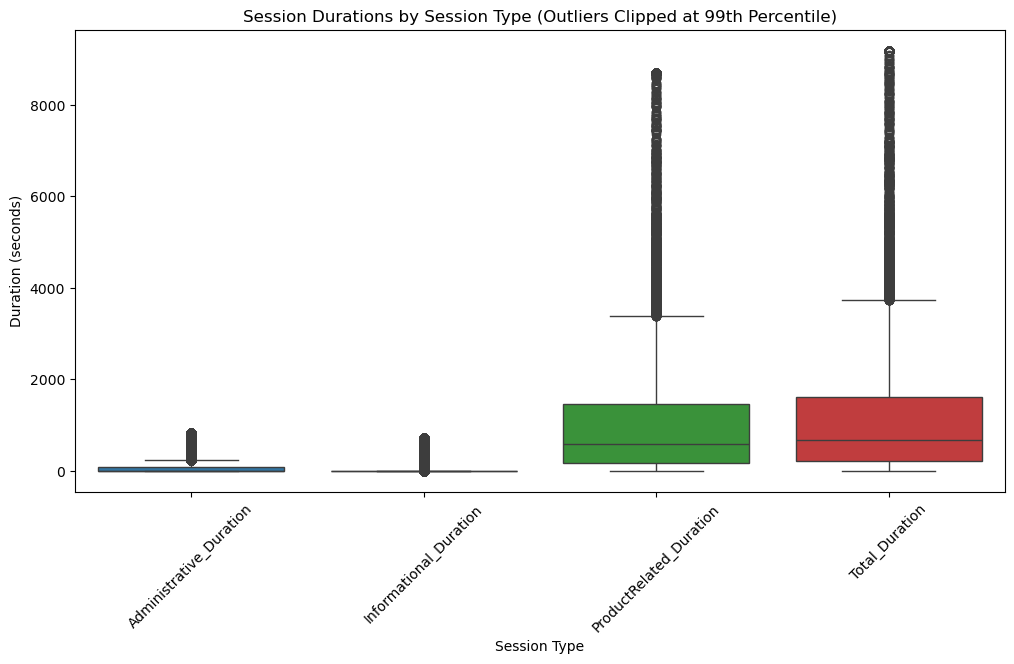

In [145]:
# Create a viz copy
df_viz = df_clean.copy()

# Clip extreme outliers
for col in num_cols:
    df_viz[col] = df_viz[col].clip(upper=df_clean[col].quantile(0.99))

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_viz[num_cols])
plt.title("Session Durations by Session Type (Outliers Clipped at 99th Percentile)")
plt.xlabel("Session Type")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.show()


#### **Diagnose for correlations between variables and determine independent and dependent variables**

In [146]:
corr = df_clean.corr(numeric_only=True)
corr


,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,Weekend,Revenue,Total_Duration,SpecialPurchase
Administrative_Duration,1.000000,0.238031,0.355422,-0.144170,-0.205798,0.014990,0.093587,0.436962,-0.008294
Informational_Duration,0.238031,1.000000,0.347364,-0.074067,-0.105276,0.024078,0.070345,0.415922,0.017110
ProductRelated_Duration,0.355422,0.347364,1.000000,-0.184541,-0.251984,0.007311,0.152373,0.993910,0.004131
BounceRates,-0.144170,-0.074067,-0.184541,1.000000,0.913004,-0.046514,-0.150673,-0.190922,-0.025292
ExitRates,-0.205798,-0.105276,-0.251984,0.913004,1.000000,-0.062587,-0.207071,-0.261759,-0.035446
Weekend,0.014990,0.024078,0.007311,-0.046514,-0.062587,1.000000,0.029295,0.009829,-0.019276
Revenue,0.093587,0.070345,0.152373,-0.150673,-0.207071,0.029295,1.000000,0.156068,0.185272
Total_Duration,0.436962,0.415922,0.993910,-0.190922,-0.261759,0.009829,0.156068,1.000000,0.004342
SpecialPurchase,-0.008294,0.017110,0.004131,-0.025292,-0.035446,-0.019276,0.185272,0.004342,1.000000


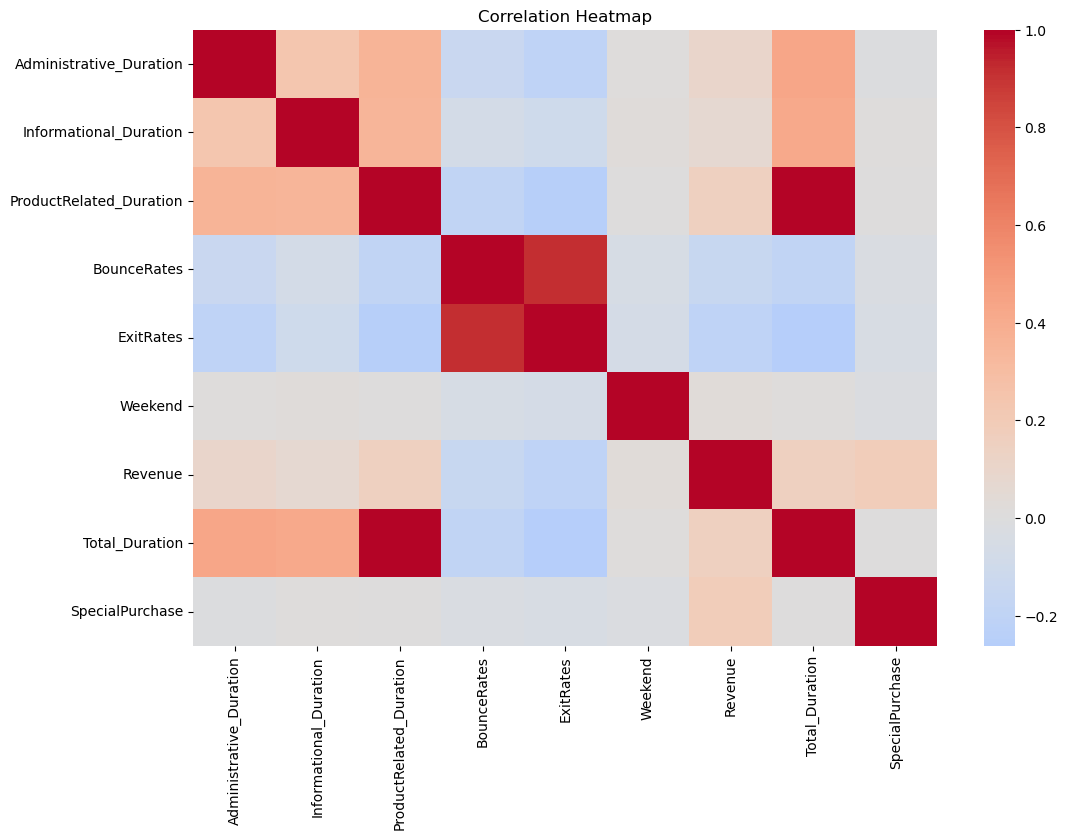

In [147]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False,cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


In [148]:
#revenue is the dependent variable, the rest of the output are the independent variables
corr_with_revenue = corr['Revenue'].sort_values(ascending=False)
#corr_with_revenue


In [149]:
#these are the independent variable with the strongest correlations
top_predictors = corr_with_revenue[abs(corr_with_revenue) > 0.1]
#top_predictors

#### **Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest**

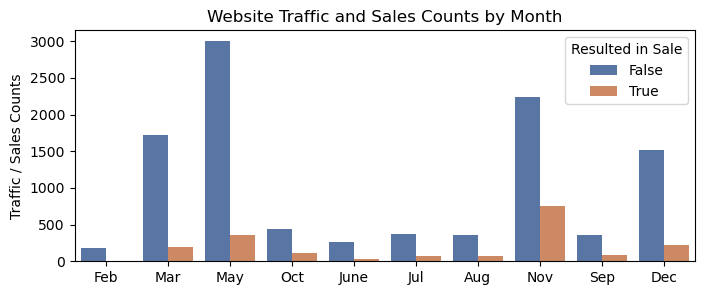

In [150]:
#look at how website traffic changes by month, and which months result in the most sales
plt.figure(figsize=(8,3))
sns.countplot(data=df_clean, x='Month', hue='Revenue', palette='deep')
plt.xlabel("")
plt.ylabel("Traffic / Sales Counts")
plt.title("Website Traffic and Sales Counts by Month")
plt.legend(title="Resulted in Sale")
plt.show()

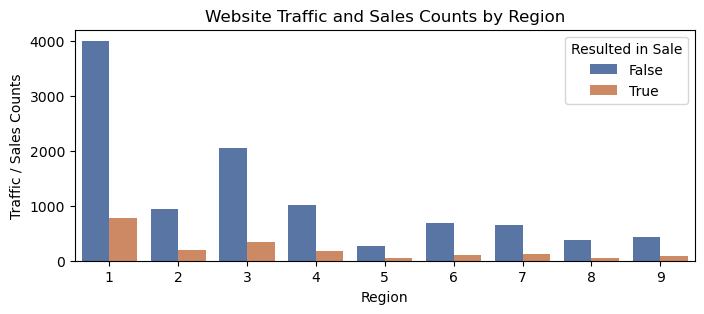

In [151]:
#look next at website traffic and sales counts by region
plt.figure(figsize=(8,3))
sns.countplot(x='Region', hue='Revenue',data =df_clean, palette='deep')
plt.xlabel("Region")
plt.ylabel("Traffic / Sales Counts")
plt.title("Website Traffic and Sales Counts by Region")
plt.legend(title="Resulted in Sale")
plt.show()

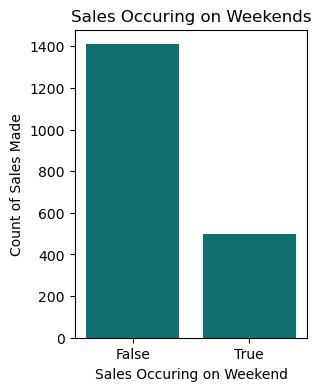

In [152]:
#understand if sales primarily occur on weekends or weekdays
df_rev=df_clean[df_clean['Revenue']]
df['Revenue'] = df_clean['Revenue'].astype(bool)
plt.figure(figsize=(3,4))
ax=sns.countplot(x='Weekend', data =df_rev, color='teal')
ax.set_xlabel("Sales Occuring on Weekend")
ax.set_ylabel("Count of Sales Made")
plt.title("Sales Occuring on Weekends")
plt.show()

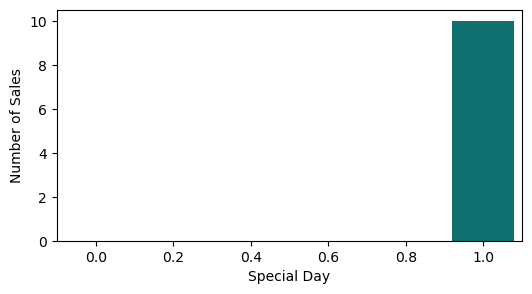

In [153]:
#See which holiday encourages the most sales
df['SpecialDay'].unique()
plt.figure(figsize=(6,3))
df_rev_special = df_rev[df_rev['SpecialDay'].astype(int) > 0]
ax1=sns.countplot(x='SpecialDay', data=df_rev_special, color='teal')
ax1.set_xlabel("Special Day")
ax1.set_ylabel("Number of Sales")
plt.show()

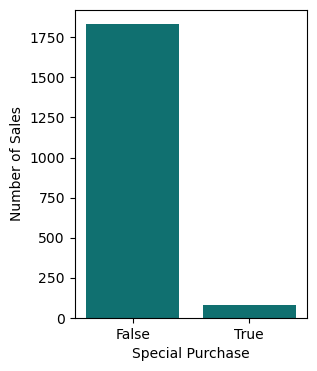

In [154]:
#understand if "special days" are a main driver of sales
plt.figure(figsize=(3,4))
ax2=sns.countplot(x='SpecialPurchase', data=df_rev, color='teal')
ax2.set_xlabel("Special Purchase")
ax2.set_ylabel("Number of Sales")
plt.show()

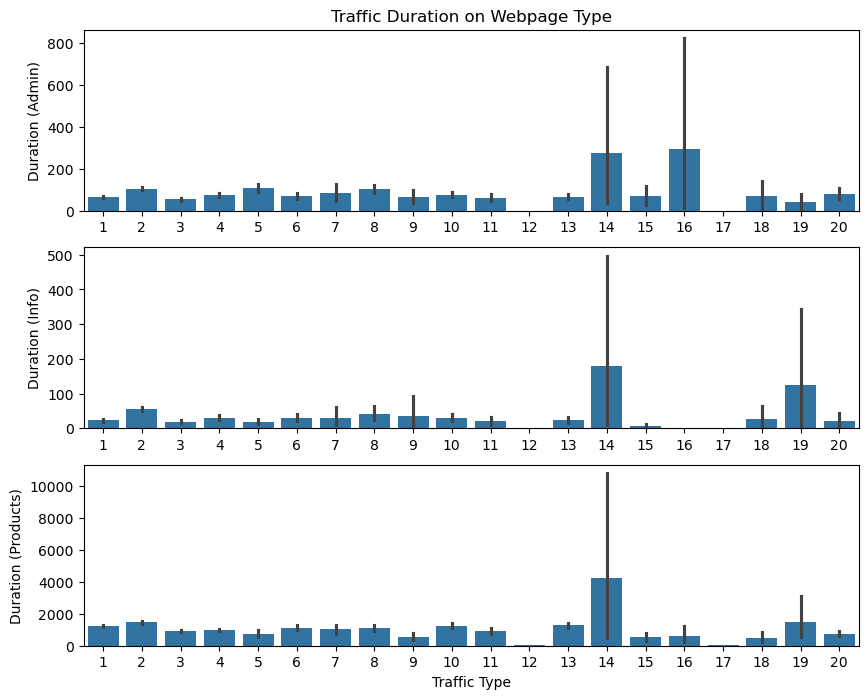

In [155]:
#learn more what "Traffic Type" might mean:
fig, axes = plt.subplots(3,1, figsize= (10,8))
sns.barplot(x='TrafficType', y='Administrative_Duration', data=df_clean, ax=axes[0])
axes[0].set_title('Traffic Duration on Webpage Type')
axes[0].set_xlabel("")
axes[0].set_ylabel("Duration (Admin)")
sns.barplot(x='TrafficType', y='Informational_Duration', data=df_clean, ax=axes[1])
#axes[1].set_title('Traffic Duration on Informational Site')
axes[1].set_xlabel("")
axes[1].set_ylabel("Duration (Info)")
sns.barplot(x='TrafficType', y='ProductRelated_Duration', data=df_clean, ax=axes[2])
#axes[2].set_title('Traffic Duration on Product-Related Site')
axes[2].set_xlabel("Traffic Type")
axes[2].set_ylabel("Duration (Products)")
plt.show()
#this is not very conclusive. 

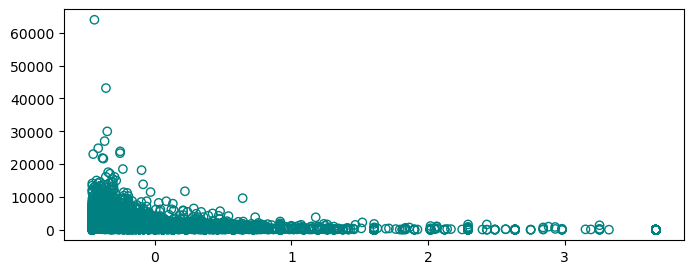

In [156]:
#explore how exit or bounce rates may be related to duration
plt.figure(figsize=(8,3))
#plt.scatter(df_clean['BounceRates'], df_clean['Administrative_Duration'], marker='s', facecolor='none', edgecolor='gold')
#plt.scatter(df_clean['ExitRates'], df_clean['Informational_Duration'], marker='o', facecolor='none', edgecolor='teal')
plt.scatter(df_clean['BounceRates'], df_clean['ProductRelated_Duration'], marker='o', facecolor='none', edgecolor='teal')
#plt.scatter(df_clean['BounceRates'], df_clean['Total_Duration'], marker='o', facecolor='none', edgecolor='teal')
plt.show()

#### Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables

In [157]:
#going with supervised method as we know the outcome: revenue or no revenue. We want the model to understand the relationship between the types of sessions and their durations and that known outcome of revenue or no revenue
#Revenue is dependent variable
#independent variables: administrative_duration, informational_duration, productrelated_duration, bouncerates, exitrates

### Train, test, and provide accuracy and evaluation metrics for model results

In [160]:
# assistance from github copilot on this portion

df_clean['RevenueBinary'] = df_clean['Revenue'].astype(int)

predictors = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'Total_Duration',
    'BounceRates',
    'ExitRates'
]

X = df_clean[predictors]
y = df_clean['RevenueBinary']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8440118951067856
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      3124
           1       0.38      0.01      0.01       575

    accuracy                           0.84      3699
   macro avg       0.61      0.50      0.46      3699
weighted avg       0.77      0.84      0.77      3699



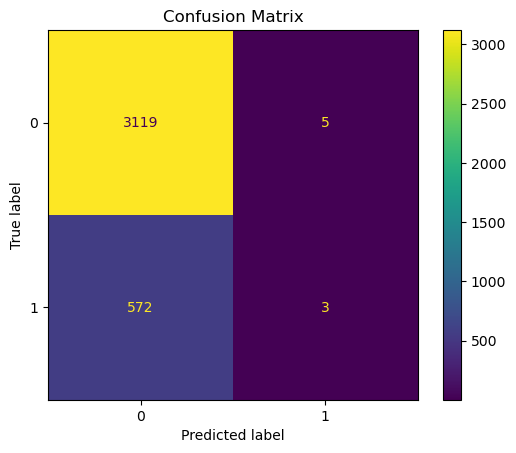

In [159]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()
